<a href="https://colab.research.google.com/github/rturquier/depythons/blob/main/Rendu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Projet informatique - Python pour le data scientist
##### Jérémie Stym-Popper, Luca Teodorescu, Rémi Turquier
# _La République en Marche_ est-elle de gauche ou de droite ?

[Titre provisoire]

In [3]:
# Imports
import pandas as pd

## Récupération des données
Les données ont été récupérées par l'intermédiaire de [l'API](https://github.com/regardscitoyens/nosdeputes.fr/blob/master/doc/api.md) mise à disposition par l'association Regards citoyens.

Nous avons d'abord utilisé un module nommé depute_api, que nous avons ensuite complété avec trois fonctions :
Les fonctions *interventions* et *interventions2* permettent d'entrer le nom d'un député pour obtenir une liste d'interventions (sous forme de liste de str).
La fonction ...

In [4]:
# ----- Codage de l'API --------------------------------------------------
from operator import itemgetter
import requests
import warnings
import re
import bs4
import unidecode
from urllib import request


with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    from fuzzywuzzy.process import extractBests


__all__ = ['CPCApi']


def memoize(f):
    cache = {}

    def aux(*args, **kargs):
        k = (args, tuple(sorted(kargs.items())))
        if k not in cache:
            cache[k] = f(*args, **kargs)
        return cache[k]
    return aux


class CPCApi(object):
    format = 'json'

    def __init__(self, ptype='depute', legislature=None):
        """
        type: depute or senateur
        legislature: 2007-2012 or None
        """

        assert(ptype in ['depute', 'senateur'])
        assert(legislature in ['2007-2012', '2012-2017', None])
        self.legislature = legislature
        self.ptype = ptype
        self.ptype_plural = ptype + 's'
        self.base_url = 'https://%s.nos%s.fr' % (legislature or 'www', self.ptype_plural)

    def synthese(self, month=None):
        """
        month format: YYYYMM
        """
        if month is None and self.legislature == '2012-2017':
            raise AssertionError('Global Synthesis on legislature does not work, see https://github.com/regardscitoyens/nosdeputes.fr/issues/69')

        if month is None:
            month = 'data'

        url = '%s/synthese/%s/%s' % (self.base_url, month, self.format)

        data = requests.get(url).json()
        return [depute[self.ptype] for depute in data[self.ptype_plural]]

    def parlementaire(self, slug_name):
        url = '%s/%s/%s' % (self.base_url, slug_name, self.format)
        return requests.get(url).json()[self.ptype]

    def picture(self, slug_name, pixels='60'):
        return requests.get(self.picture_url(slug_name, pixels=pixels))

    def picture_url(self, slug_name, pixels='60'):
        return '%s/%s/photo/%s/%s' % (self.base_url, self.ptype, slug_name, pixels)

    def search(self, q, page=1):
        # XXX : the response with json format is not a valid json :'(
        # Temporary return csv raw data
        url = '%s/recherche/%s?page=%s&format=%s' % (self.base_url, q, page, 'csv')
        return requests.get(url).content
    
    
    @memoize
    def parlementaires(self, active=None):
        if active is None:
            url = '%s/%s/%s' % (self.base_url, self.ptype_plural, self.format)
        else:
            url = '%s/%s/enmandat/%s' % (self.base_url, self.ptype_plural, self.format)

        data = requests.get(url).json()
        return [depute[self.ptype] for depute in data[self.ptype_plural]]
    
    def search_parlementaires(self, q, field='nom', limit=5):
        return extractBests(q, self.parlementaires(), processor=lambda x: x[field] if type(x) == dict else x, limit=limit)



    def interventions(self, dep_name, n_sessions=10, start=4850):
        name = self.search_parlementaires(dep_name)[0][0]["nom"]
        dep_intervention = []
        pattern = "(?<=Permalien" + name + ")" + ".*?(?=Voir tous les commentaires)"
        for num_txt in range(start, start + n_sessions):
            url = "https://www.nosdeputes.fr/15/seance/%s" % (str(num_txt))
            source = request.urlopen(url).read()            
            # source.encoding = source.apparent_encoding
            page = bs4.BeautifulSoup(source, "lxml")
            x = re.findall(pattern, page.get_text(), flags=re.S)
            dep_intervention += x

        return dep_intervention
    
    def interventions2(self, dep_name):
        name = self.search_parlementaires(dep_name)[0][0]["nom"]
        name_pattern = re.sub(' ', '+', unidecode.unidecode(name.lower()))
        dep_intervention = []
        url = "https://www.nosdeputes.fr/recherche?object_name=Intervention&tag=parlementaire%3D{0}&sort=1".format(name_pattern)
        source = request.urlopen(url).read()            
        page = bs4.BeautifulSoup(source, "lxml")
        for x in page.find_all('p', {'class' : 'content'}):
            dep_intervention += x

        return dep_intervention
    
    def liste_mots(self, dep_name):
        name = self.search_parlementaires(dep_name)[0][0]["nom"]
        name_pattern = re.sub(' ', '-', unidecode.unidecode(name.lower()))
        mots_dep = []
        url = "https://www.nosdeputes.fr/{0}/tags".format(name_pattern)
        source = request.urlopen(url).read()            
        page = bs4.BeautifulSoup(source, "lxml")
        for x in page.find_all('span', {'class' : 'tag_level_4'}):
            mots_dep.append(re.sub("\n", "", x.get_text()))
            
        return mots_dep


Ensuite, nous avons créé plusieurs DataFrames à l'aide de la fonction interventions 2, avec les fonctions suivantes : 

In [5]:
# Fonctions intermédiaires

def deputies_of_group(group, n_deputies):
    all_names = deputies_df[deputies_df["groupe_sigle"] == group]["nom"]
    return all_names[:n_deputies]


def interventions_of_group(group, n_deputies=15):
    names = deputies_of_group(group, n_deputies)
    print(names)
    interventions = []
    for name in names:
        print(name)
        interventions += [[group, name, api.interventions2(name)]]
    return interventions

# Fonction de stockage des interventions 

def stockintervention(groupe):
    interventions_group = []
    nbdep = deputies_df.groupby('groupe_sigle')['nom'].count()[str(groupe)]
    print(nbdep)
    interventions_group += interventions_of_group(groupe, nbdep)
    interventions_df = pd.DataFrame(
        interventions_group,
        columns=["groupe", "nom", "interventions"]
        )
    
    return interventions_df

Voici un exemple d'utilisation. Pour éviter de perdre du temps ici (la fonction peut mettre du temps à s'exécuter sur les échantillons de grande taille), on exécute la fonction sur un petit parti politique.

In [6]:
api = CPCApi()
deputies_json = api.parlementaires()
deputies_df = pd.json_normalize(deputies_json)

UAI_df = stockintervention('UAI')
UAI_df

4
76           Yves Jégo
80      Franck Riester
289      Maurice Leroy
515    Napole Polutele
Name: nom, dtype: object
Yves Jégo
Franck Riester
Maurice Leroy
Napole Polutele


,groupe,nom,interventions
0,UAI,Yves Jégo,"[Yves Jégo Prochaine séance, ce soir, à vingt..."
1,UAI,Franck Riester,"[ Vous pouvez compter sur le groupe UDI, Agir ..."
2,UAI,Maurice Leroy,[Maurice Leroy – Nous avons examiné la PPE en...
3,UAI,Napole Polutele,"[ Oui, madame la présidente. , Madame la mini..."


Importons maintenant les données qui nous intéressent

In [7]:
LFI_df = pd.read_csv("https://raw.githubusercontent.com/rturquier/depythons/main/Stock_csv/LFI2_inter.csv")
LREM_df = pd.read_csv("https://raw.githubusercontent.com/rturquier/depythons/main/Stock_csv/LREM2_inter.csv")
LR_df = pd.read_csv("https://raw.githubusercontent.com/rturquier/depythons/main/Stock_csv/LR2_inter.csv")
SOC_df = pd.read_csv("https://raw.githubusercontent.com/rturquier/depythons/main/Stock_csv/SOC2_inter.csv")

## Nettoyage des données
Après une exploration préliminaire, nous avons choisi de nous concentrer sur deux groupes parlementaires. Les groupes LFI et LR nous ont paru ceux les plus susceptibles d'utiliser un discours différent et que nous pourrions distinguer dans notre modèle. 

In [8]:
### Import des données brutes récupérées avec l'API
data_url = "https://raw.githubusercontent.com/rturquier/depythons/main/Stock_csv/gd2_inter.csv"
df_brut = pd.read_csv(data_url)
df_brut.sample(n=5)

,groupe,nom,interventions
73,LR,Jean-Yves Bony,"[' Il a dit une énormité… ', ' Excellent ! ', ..."
116,LR,Patrick Hetzel,"["" Ce texte ouvre la voie à des recrutements e..."
46,LR,Gérard Cherpion,"["" L'article 2 précise le champ d'application ..."
19,LR,Damien Abad,"["" Cela va être dur de défendre l'indéfendable..."
64,LR,Michel Herbillon,"[' Elles sont nombreuses ! ', "" C'est le minis..."


In [9]:
# Création d'une indicatrice `droite` qui sera la cible de la classification
df_brut = df_brut.assign(droite = df_brut["groupe"] == "LR")

In [10]:
# Équilibrage du nombre de députés
def balance_left_right(df):
  count = df.droite.value_counts()
  n_droite, n_gauche = count[True], count[False]
  df = df.sort_values(by = ["droite"], ascending = False)
  
  if n_droite > n_gauche :
    df = df[n_droite - n_gauche:]
  elif n_droite < n_gauche :
    df = df[2 * n_droite:]

  return df

df_brut = balance_left_right(df_brut)
df_brut.droite.value_counts()

True     51
False    51
Name: droite, dtype: int64

In [11]:
# Régler un problème de type
from ast import literal_eval
def convert_to_list(interventions):
  return literal_eval(str(interventions))

df_brut["interventions"] = df_brut["interventions"].apply(convert_to_list)

In [12]:
# Séparer toutes les interventions en colonnes différentes
df_tidy = df_brut.explode("interventions")
df_tidy

,groupe,nom,interventions,droite
71,LR,Laurence Trastour-Isnart,Il vise à supprimer la part salariale de la s...,True
71,LR,Laurence Trastour-Isnart,Ces sous-amendements dus à mon collègue Ferra...,True
71,LR,Laurence Trastour-Isnart,Il est beaucoup question de l'égalité entre h...,True
71,LR,Laurence Trastour-Isnart,Toutes les dispositions nécessaires ont été m...,True
71,LR,Laurence Trastour-Isnart,"Mes chers collègues, nous vous demandons simp...",True
...,...,...,...,...
167,SOC,Isabelle Santiago,Il vise également à supprimer l'alinéa 16. Le...,False
167,SOC,Isabelle Santiago,"Monsieur le Premier ministre, conséquence dir...",False
167,SOC,Isabelle Santiago,Le présent amendement propose de supprimer l'...,False
167,SOC,Isabelle Santiago,Il vise à instaurer un prélèvement sur les re...,False


In [13]:
# Créer une feature "longeur de l'intervention"
df_brut = df_brut.assign(longeur = df_brut["interventions"].str.len())
df_brut

,groupe,nom,interventions,droite,longeur
71,LR,Laurence Trastour-Isnart,[ Il vise à supprimer la part salariale de la ...,True,50
66,LR,Marc Le Fur,"[Marc Le Fur Prochaine séance, demain, à neuf...",True,50
41,LR,Nicolas Forissier,[ Je ne vais pas reprendre les excellents argu...,True,50
39,LR,Jean-Jacques Gaultier,[ … mais contre votre gestion de la crise. Mai...,True,50
38,LR,Pierre-Henri Dumont,[ Il procède de la même logique que les ceux p...,True,50
...,...,...,...,...,...
136,SOC,Marietta Karamanli,[ Je vous remercie de ces éléments et de votre...,False,50
137,SOC,Joël Aviragnet,"[ Il vise, lui aussi, à supprimer l'article in...",False,50
138,SOC,Boris Vallaud,[ Quelle incongruité que la majorité pénale so...,False,50
139,SOC,Alain David,[ Déposé par le groupe Socialistes et apparent...,False,50


## Exploration et feature engineering

In [14]:
# Il faudrait faire un test-train-split ici, je crois

In [15]:
# Création de features simples : 
# - longueur de l'intervention, en nombre de caractères
# - nombre de points d'exclamation
# - nombre de points d'interrogation
df_tidy = df_tidy.assign(
    longueur = df_tidy["interventions"].str.len(),
    exclamation = df_tidy["interventions"].str.count("!"),
    interrogation = df_tidy["interventions"].str.count("\?")
    )

## Visualisation des données (wordcloud, statistiques descriptives...)

Nous allons maintenant dans cette partie visualiser les tendances dans les différents partis, ainsi que les mots qui sont les plus utilisés. Nous commençons par le wordcloud.

In [18]:
# Imports

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

%matplotlib inline

from urllib import request

# Création d'un stopwords

stopping_list = request.urlopen("https://raw.githubusercontent.com/rturquier/depythons/main/stopwords-fr.txt").read()
stopping_list = stopping_list.decode('utf-8')
stopwords_list = stopping_list.split('\n')

def wordcloud_gen(dep_name):
    name = api.search_parlementaires(dep_name)[0][0]['nom']
    text_dep = api.interventions2(name)
    
    text_cloud = ""
    for morceau in text_dep:
        text_cloud += morceau
    
    stopwords = set(STOPWORDS)  
    stopwords.update(stopwords_list)

    try_cloud = WordCloud(stopwords = stopwords,
                          max_font_size=50, max_words=150, 
                          background_color="white").generate(text_cloud)

    plt.imshow(try_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(name)
    plt.show()

Quelques petits essais...

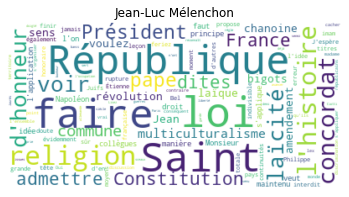

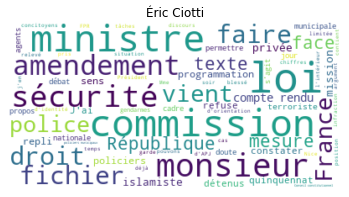

(None, None)

In [19]:
wordcloud_gen("Jean-Luc Mélenchon"), wordcloud_gen('Eric Ciotti')

### Liste de mots customisée

Créons dès à présent une fonction qui retourne les mots les plus utilisés par les membres d'un parti. Cette liste de mots va nous servir pour modéliser les champs lexicaux (quel parti a le plus tendance à utiliser tel mot ?). 

In [ ]:
from collections import Counter

def give_text(groupe_df):
    list_groupe = []
    for words in groupe_df['interventions']:
        list_groupe.append(words)
        
    text_groupe = ""
    
    for block in list_groupe:
        for carac in block:
            text_groupe += carac
            
    return text_groupe



def customized(parti_df, nb_mots=100):
    parti_split = give_text(parti_df).split()
    parti_pure = [word for word in parti_split if word not in stopwords_list]
    parti_counter = Counter(parti_pure)
    parti_commons = parti_counter.most_common(nb_mots)
    
    customized_list = []
    for x in parti_commons:
        customized_list.append(x[0])
    
    return customized_list

Utilisons ces fonctions pour créer une liste de mots customisée, qui contient les mots les plus utilisés, partis de gauche et de droite confondus.

In [ ]:
super_liste = customized(LFI_df) + customized(LR_df) + customized(SOC_df)
super_liste = list(set(super_liste)) # Suppression des doublons
super_liste

['France',
 'Mais',
 'demande',
 'finances',
 'amendement,',
 'public',
 'besoin',
 'nationale',
 'mesure',
 "l'enseignement",
 'Cette',
 'supprimer',
 'Or',
 'Par',
 'Gouvernement',
 'crise',
 "L'amendement",
 'rapport',
 'compte',
 'politique',
 'Très',
 'Dans',
 'uniquement',
 'On',
 'service',
 'femmes',
 'mesures',
 "s'agit",
 "d'autres",
 'milliards',
 'prévoit',
 'Madame',
 'faut',
 'Et',
 'situation',
 'aides',
 'matière',
 'mois',
 'De',
 'crédits',
 'rapporteur',
 'effet,',
 'no',
 'également',
 'soutenir',
 'titre',
 'sociale',
 'madame',
 "j'ai",
 'secteur',
 'droits',
 'M.',
 "l'ensemble",
 'proposons',
 'cas',
 'Ils',
 'Mme',
 'santé',
 'apparentés',
 'sanitaire',
 'temps',
 '»,',
 'raison',
 'territoires',
 'ans',
 'euros',
 'faire',
 'groupe',
 'projet',
 'part',
 'que,',
 'nombre',
 "l'on",
 'vise',
 'mission',
 'amendement',
 'établissements',
 'Socialistes',
 'texte',
 'vidéo)',
 'recherche',
 'pays',
 'prendre',
 'supplémentaires',
 '"Bénédicte',
 'droit',
 'cadre',